In [1]:
import pandas as pd

In [54]:
import zipfile
import pandas as pd

zip_path = "data.csv.zip"

with zipfile.ZipFile(zip_path) as z:
    csv_filename = [f for f in z.namelist() if f.endswith(".csv")][0]
    # Try with encoding
    df = pd.read_csv(z.open(csv_filename), encoding="latin1")  # or "ISO-8859-1" / "cp1252"

print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [55]:
df_sorted = df.sort_values(by=["InvoiceNo", "InvoiceDate"])
df_sorted.to_csv("cleaned_data.csv", index=False)

In [30]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [62]:
df = pd.read_csv("cleaned_data.csv", encoding="latin1", low_memory=False)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [63]:
# Drop missing CustomerID
df = df.dropna(subset=["CustomerID"])

# Remove negative/zero quantities & prices
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [65]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [66]:
df.shape

(397884, 8)

In [67]:
NOW = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (NOW - x.max()).days,
    "InvoiceNo": "count",
    "Quantity": "sum",
    "UnitPrice": "mean"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "TotalQty", "AvgUnitPrice"]

# Monetary = Quantity * UnitPrice
df["Sales"] = df["Quantity"] * df["UnitPrice"]
monetary = df.groupby("CustomerID")["Sales"].sum().reset_index()
rfm = rfm.merge(monetary, on="CustomerID")
rfm.rename(columns={"Sales": "Monetary"}, inplace=True)

rfm.head()


,CustomerID,Recency,Frequency,TotalQty,AvgUnitPrice,Monetary
0,12346.0,326,1,74215,1.040000,77183.60
1,12347.0,2,182,2458,2.644011,4310.00
2,12348.0,75,31,2341,5.764839,1797.24
3,12349.0,19,73,631,8.289041,1757.55
4,12350.0,310,17,197,3.841176,334.40


In [68]:
X = rfm[["Recency", "Frequency", "TotalQty", "AvgUnitPrice", "Monetary"]].copy()

# invert Recency (so lower recency = better)
X["RecencyInv"] = X["Recency"].max() - X["Recency"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[["RecencyInv", "Frequency", "TotalQty", "AvgUnitPrice", "Monetary"]])


In [73]:
df = pd.read_csv("cleaned_data.csv", encoding="latin1", low_memory=False)

# Drop missing IDs
df = df.dropna(subset=["CustomerID"])

# Remove negative values
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [74]:
NOW = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (NOW - x.max()).days,
    "InvoiceNo": "count",
    "Quantity": "sum",
    "UnitPrice": "mean"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "TotalQty", "AvgUnitPrice"]

df["Sales"] = df["Quantity"] * df["UnitPrice"]
monetary = df.groupby("CustomerID")["Sales"].sum().reset_index()
rfm = rfm.merge(monetary, on="CustomerID")
rfm.rename(columns={"Sales": "Monetary"}, inplace=True)


In [76]:
from sklearn.decomposition import FactorAnalysis

In [77]:
fa = FactorAnalysis(n_components=3, random_state=42)
X_fa = fa.fit_transform(X_scaled)

print("Explained variance per factor (approx):")
print(np.var(X_fa, axis=0) / np.var(X_scaled, axis=0).sum())

Explained variance per factor (approx):
[0.19231043 0.05801086 0.01868501]


In [79]:
# If your RFM features DataFrame is called `rfm`
rfm["Cluster"] = labels

# Save
rfm.to_csv("outputs/customer_segments_fa.csv", index=False)

In [80]:
rfm_model = rfm.copy()


In [81]:
rfm_model = rfm.copy()
rfm_model["Cluster"] = labels
rfm_model.to_csv("outputs/customer_segments_fa.csv", index=False)


C:\Users\hp\anaconda2\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


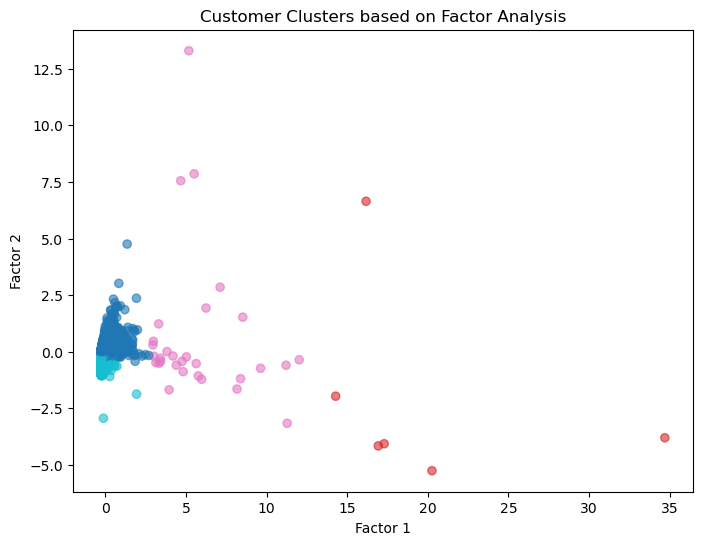

In [82]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Cluster using factor scores
kmeans = KMeans(n_clusters=4, random_state=42)  # you can tune n_clusters
labels = kmeans.fit_predict(X_fa)

# Add cluster labels back to your RFM data
rfm_model["Cluster"] = labels

# Save results
rfm_model.to_csv("outputs/customer_segments_fa.csv", index=False)

# Plot factor scores with clusters
plt.figure(figsize=(8,6))
plt.scatter(X_fa[:,0], X_fa[:,1], c=labels, cmap="tab10", alpha=0.6)
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.title("Customer Clusters based on Factor Analysis")
plt.show()


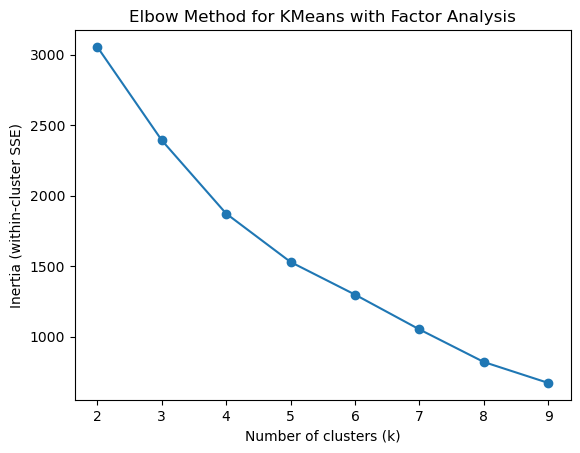

In [83]:
inertias = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_fa)
    inertias.append(km.inertia_)

plt.plot(range(2, 10), inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method for KMeans with Factor Analysis")
plt.show()

In [84]:
rfm_model["Cluster"] = labels
cluster_profile = rfm_model.groupby("Cluster").mean()
print(cluster_profile)

           CustomerID     Recency    Frequency      TotalQty  AvgUnitPrice  \
Cluster                                                                      
0        15284.689311   38.589504   105.180296   1062.425950      3.295389   
1        15661.666667    6.166667  1539.333333  94944.666667      3.266758   
2        15096.133333   25.533333  1058.066667  32225.733333      3.891616   
3        15344.540970  234.750000    25.264214    277.154682      7.532919   

              Monetary  
Cluster                 
0          1817.782422  
1        195271.033333  
2         48900.392000  
3           524.028212  


In [85]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_fa)
rfm_model["Cluster"] = labels

In [87]:
import seaborn as sns

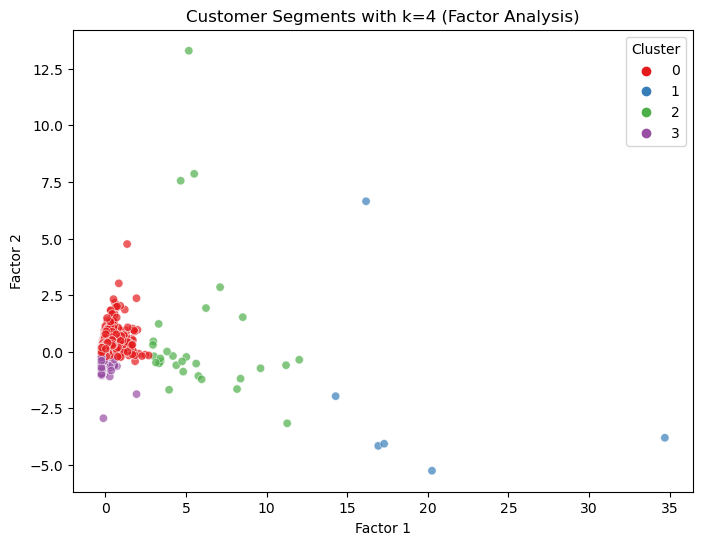

In [88]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_fa[:,0], y=X_fa[:,1], hue=labels, palette="Set1", alpha=0.7)
plt.title("Customer Segments with k=4 (Factor Analysis)")
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.legend(title="Cluster")
plt.show()


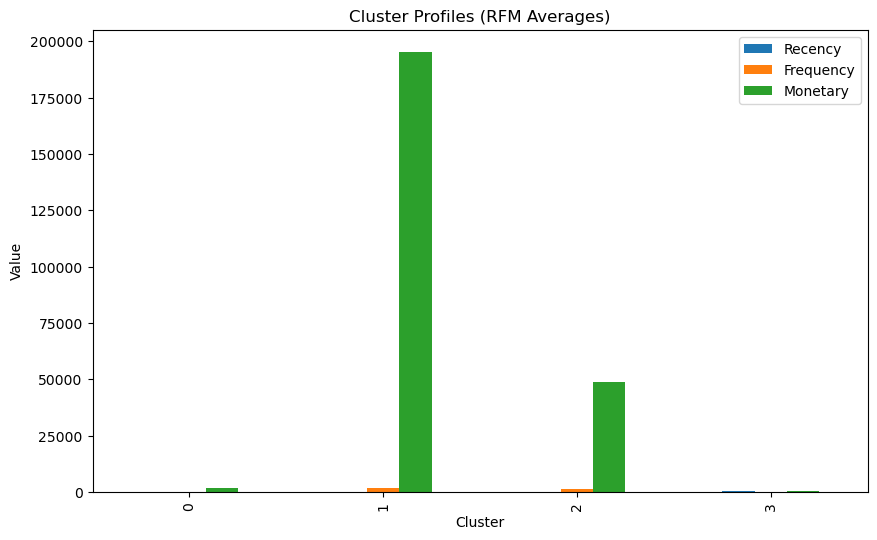

In [91]:

import matplotlib.pyplot as plt

# Plot for R, F, M across clusters
cluster_profile = rfm_model.groupby("Cluster").mean()[["Recency", "Frequency", "Monetary"]]

cluster_profile.plot(kind="bar", figsize=(10,6))
plt.title("Cluster Profiles (RFM Averages)")
plt.ylabel("Value")
plt.show()


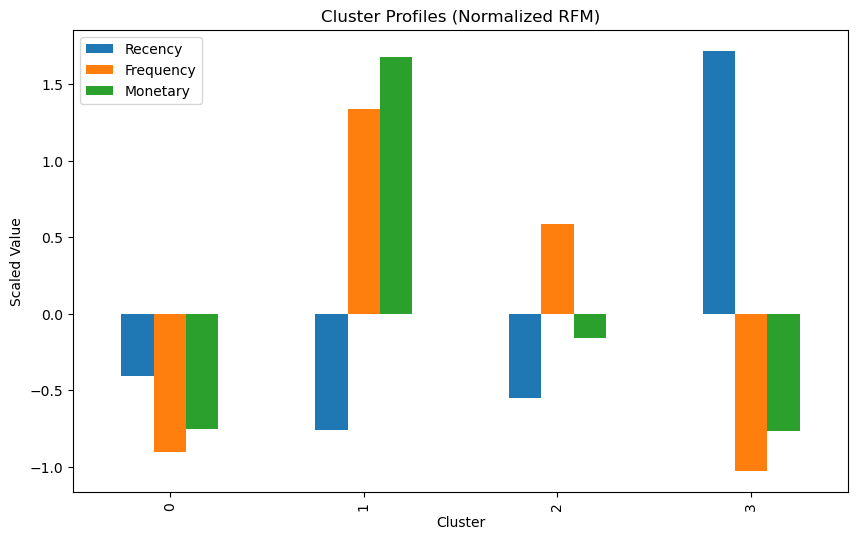

In [92]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaled_profile = StandardScaler().fit_transform(cluster_profile)

# Convert back to DataFrame for plotting
scaled_profile = pd.DataFrame(scaled_profile, 
                              index=cluster_profile.index, 
                              columns=cluster_profile.columns)

# Plot normalized values
scaled_profile.plot(kind="bar", figsize=(10,6))
plt.title("Cluster Profiles (Normalized RFM)")
plt.ylabel("Scaled Value")
plt.show()


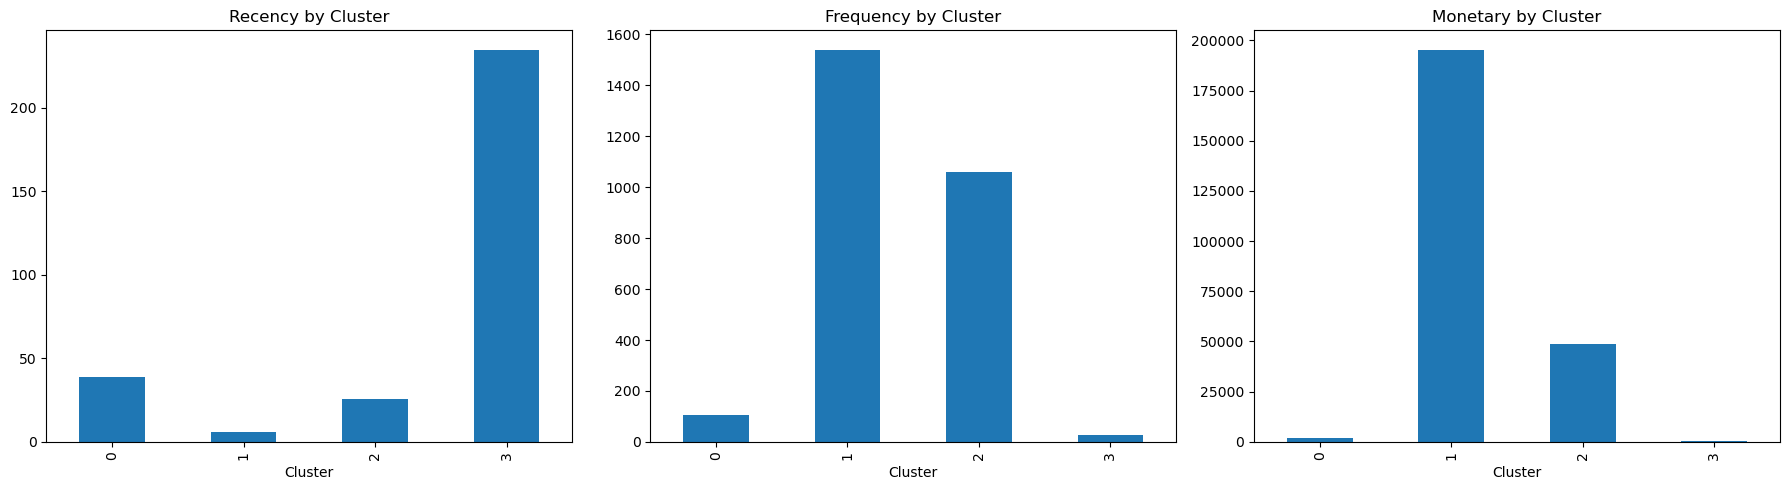

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

cluster_profile["Recency"].plot(kind="bar", ax=axes[0], title="Recency by Cluster")
cluster_profile["Frequency"].plot(kind="bar", ax=axes[1], title="Frequency by Cluster")
cluster_profile["Monetary"].plot(kind="bar", ax=axes[2], title="Monetary by Cluster")

plt.tight_layout()
plt.show()


In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [96]:
from sklearn.preprocessing import StandardScaler

# Select RFM features only
rfm_features = rfm_model[['Recency', 'Frequency', 'Monetary']]

# Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)


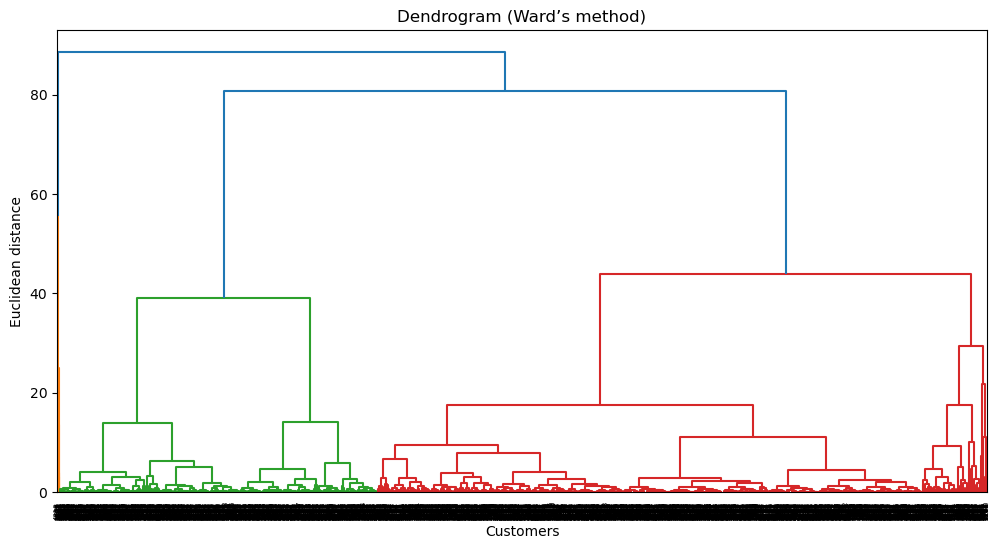

In [97]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
dendrogram = sch.dendrogram(sch.linkage(rfm_scaled, method='ward'))
plt.title("Dendrogram (Ward’s method)")
plt.xlabel("Customers")
plt.ylabel("Euclidean distance")
plt.show()


In [98]:
from sklearn.cluster import AgglomerativeClustering

# Fit Hierarchical clustering
hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hc_labels = hc.fit_predict(rfm_scaled)

# Add to your dataset
rfm_model['HC_Cluster'] = hc_labels

# Cluster profile
hc_profile = rfm_model.groupby("HC_Cluster").mean()
print(hc_profile)


C:\Users\hp\anaconda2\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


              CustomerID     Recency    Frequency      TotalQty  AvgUnitPrice  \
HC_Cluster                                                                      
0           15290.117833   31.464298   112.339782   1356.914527      4.332227   
1           15818.000000    7.000000   846.285714  87405.285714      3.017123   
2           15318.762129  210.183962    33.254717    372.528302      4.735335   
3           14899.000000    2.000000  5807.000000  36358.750000      4.080412   

                 Monetary   Cluster  
HC_Cluster                           
0             2277.691767  0.020753  
1           176606.164286  1.285714  
2              617.241180  2.411725  
3            70925.287500  1.750000  


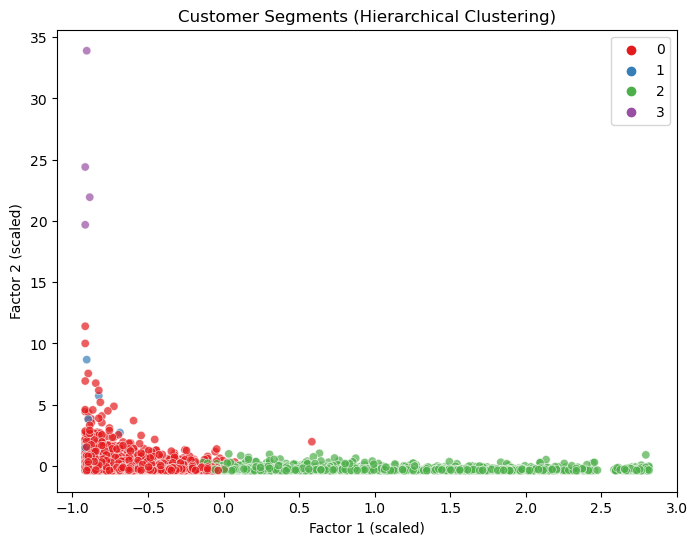

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(x=rfm_scaled[:,0], y=rfm_scaled[:,1], hue=hc_labels, palette="Set1", alpha=0.7)
plt.title("Customer Segments (Hierarchical Clustering)")
plt.xlabel("Factor 1 (scaled)")
plt.ylabel("Factor 2 (scaled)")
plt.show()


In [100]:
# KMeans clusters (you already had this earlier as 'Cluster')
kmeans_profile = rfm_model.groupby("Cluster").mean()

# Hierarchical clusters (we added as 'HC_Cluster')
hc_profile = rfm_model.groupby("HC_Cluster").mean()

# Combine results for comparison
comparison = pd.concat(
    [kmeans_profile.add_suffix("_KMeans"),
     hc_profile.add_suffix("_Hierarchical")],
    axis=1
)

print(comparison)


   CustomerID_KMeans  Recency_KMeans  Frequency_KMeans  TotalQty_KMeans  \
0       15284.689311       38.589504        105.180296      1062.425950   
1       15661.666667        6.166667       1539.333333     94944.666667   
2       15096.133333       25.533333       1058.066667     32225.733333   
3       15344.540970      234.750000         25.264214       277.154682   

   AvgUnitPrice_KMeans  Monetary_KMeans  HC_Cluster_KMeans  \
0             3.295389      1817.782422           0.187379   
1             3.266758    195271.033333           1.333333   
2             3.891616     48900.392000           0.366667   
3             7.532919       524.028212           1.994983   

   CustomerID_Hierarchical  Recency_Hierarchical  Frequency_Hierarchical  \
0             15290.117833             31.464298              112.339782   
1             15818.000000              7.000000              846.285714   
2             15318.762129            210.183962               33.254717   
3        

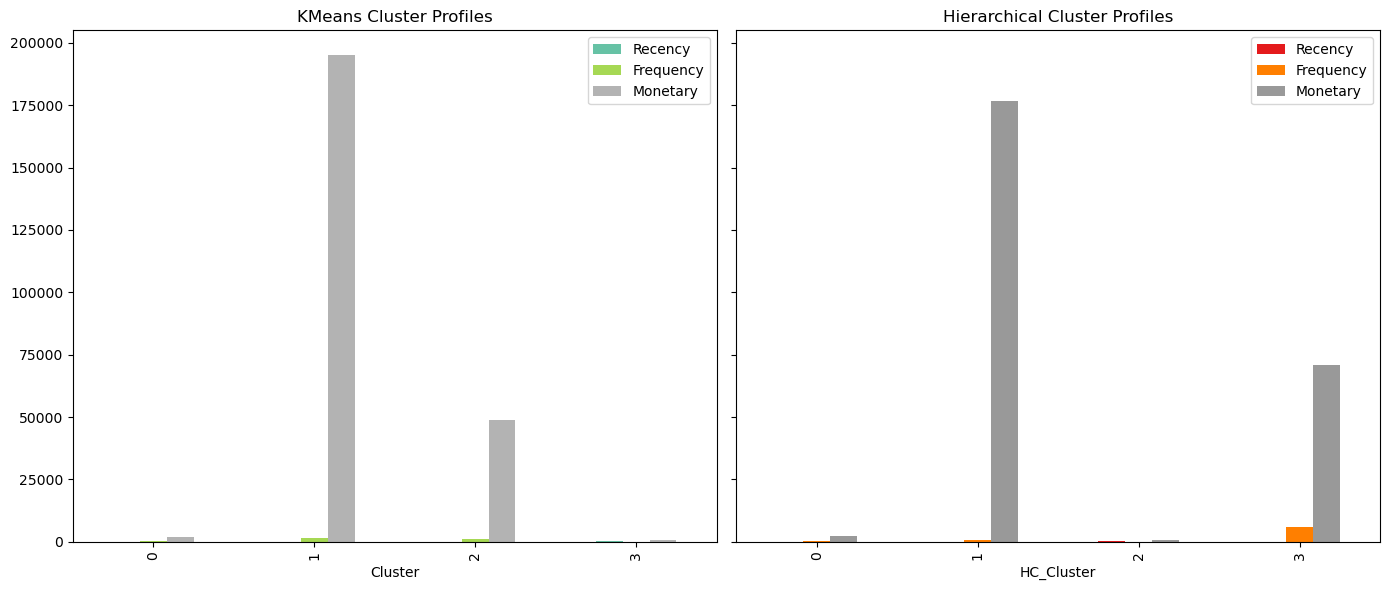

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# KMeans profiles
kmeans_profile[['Recency','Frequency','Monetary']].plot(kind='bar', ax=axes[0], colormap="Set2")
axes[0].set_title("KMeans Cluster Profiles")

# Hierarchical profiles
hc_profile[['Recency','Frequency','Monetary']].plot(kind='bar', ax=axes[1], colormap="Set1")
axes[1].set_title("Hierarchical Cluster Profiles")

plt.tight_layout()
plt.show()
